In [14]:
with open('seeds.txt', 'r') as f:
    SEEDS = [int(line.strip()) for line in f.readlines()]
    
print("SEEDS:", SEEDS)

SEEDS: [42, 100, 1, 10, 20]


Loaded labeled CSV rows: 46564
Unique time_steps: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(18), np.int64(19), np.int64(20), np.int64(21), np.int64(22), np.int64(23), np.int64(24), np.int64(25), np.int64(26), np.int64(27), np.int64(28), np.int64(29), np.int64(30), np.int64(31), np.int64(32), np.int64(33), np.int64(34), np.int64(35), np.int64(36), np.int64(37), np.int64(38), np.int64(39), np.int64(40), np.int64(41), np.int64(42), np.int64(43), np.int64(44), np.int64(45), np.int64(46), np.int64(47), np.int64(48), np.int64(49)]
Label distribution:
 class
2.0    42019
1.0     4545
Name: count, dtype: int64

=== Run 1/5, Random State 42 ===

===== Warm-up stage: Isolation Forest =====


/var/folders/2v/617m0pq96qq942zr8nbfyzch0000gn/T/ipykernel_21374/3498716504.py:65: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  labeled_pool = pd.concat([labeled_pool, batch], ignore_index=True)


Warm-up selected 1450 samples.
Warm-up found 1 illicit samples.

===== Active Learning loop: Expected Model Change =====
[Run 42] XGBoost_Model_01 illicit F1-score: 0.0000
[Run 42] XGBoost_Model_02 illicit F1-score: 0.6038
[Run 42] XGBoost_Model_03 illicit F1-score: 0.5877
[Run 42] XGBoost_Model_04 illicit F1-score: 0.6042
[Run 42] XGBoost_Model_05 illicit F1-score: 0.6802
[Run 42] XGBoost_Model_06 illicit F1-score: 0.7535
[Run 42] XGBoost_Model_07 illicit F1-score: 0.7183
[Run 42] XGBoost_Model_08 illicit F1-score: 0.7686
[Run 42] XGBoost_Model_09 illicit F1-score: 0.8048
[Run 42] XGBoost_Model_10 illicit F1-score: 0.7983
[Run 42] XGBoost_Model_11 illicit F1-score: 0.8013
[Run 42] XGBoost_Model_12 illicit F1-score: 0.8073
[Run 42] XGBoost_Model_13 illicit F1-score: 0.8023
[Run 42] XGBoost_Model_14 illicit F1-score: 0.7841
[Run 42] XGBoost_Model_15 illicit F1-score: 0.7963
[Run 42] XGBoost_Model_16 illicit F1-score: 0.8101
[Run 42] XGBoost_Model_17 illicit F1-score: 0.8012
[Run 42] XGB

/var/folders/2v/617m0pq96qq942zr8nbfyzch0000gn/T/ipykernel_21374/3498716504.py:65: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  labeled_pool = pd.concat([labeled_pool, batch], ignore_index=True)


Warm-up selected 2350 samples.
Warm-up found 1 illicit samples.

===== Active Learning loop: Expected Model Change =====
[Run 100] XGBoost_Model_01 illicit F1-score: 0.0000
[Run 100] XGBoost_Model_02 illicit F1-score: 0.0000
[Run 100] XGBoost_Model_03 illicit F1-score: 0.0018
[Run 100] XGBoost_Model_04 illicit F1-score: 0.0107
[Run 100] XGBoost_Model_05 illicit F1-score: 0.0462
[Run 100] XGBoost_Model_06 illicit F1-score: 0.6329
[Run 100] XGBoost_Model_07 illicit F1-score: 0.7437
[Run 100] XGBoost_Model_08 illicit F1-score: 0.7481
[Run 100] XGBoost_Model_09 illicit F1-score: 0.7592
[Run 100] XGBoost_Model_10 illicit F1-score: 0.7661
[Run 100] XGBoost_Model_11 illicit F1-score: 0.7846
[Run 100] XGBoost_Model_12 illicit F1-score: 0.7998
[Run 100] XGBoost_Model_13 illicit F1-score: 0.7947
[Run 100] XGBoost_Model_14 illicit F1-score: 0.8093
[Run 100] XGBoost_Model_15 illicit F1-score: 0.8155
[Run 100] XGBoost_Model_16 illicit F1-score: 0.7858
[Run 100] XGBoost_Model_17 illicit F1-score: 0.

/var/folders/2v/617m0pq96qq942zr8nbfyzch0000gn/T/ipykernel_21374/3498716504.py:65: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  labeled_pool = pd.concat([labeled_pool, batch], ignore_index=True)



===== Active Learning loop: Expected Model Change =====
[Run 1] XGBoost_Model_01 illicit F1-score: 0.0000
[Run 1] XGBoost_Model_02 illicit F1-score: 0.0000
[Run 1] XGBoost_Model_03 illicit F1-score: 0.0000
[Run 1] XGBoost_Model_04 illicit F1-score: 0.0035
[Run 1] XGBoost_Model_05 illicit F1-score: 0.0000
[Run 1] XGBoost_Model_06 illicit F1-score: 0.0375
[Run 1] XGBoost_Model_07 illicit F1-score: 0.0649
[Run 1] XGBoost_Model_08 illicit F1-score: 0.4306
[Run 1] XGBoost_Model_09 illicit F1-score: 0.6537
[Run 1] XGBoost_Model_10 illicit F1-score: 0.7087
[Run 1] XGBoost_Model_11 illicit F1-score: 0.7917
[Run 1] XGBoost_Model_12 illicit F1-score: 0.7940
[Run 1] XGBoost_Model_13 illicit F1-score: 0.7863
[Run 1] XGBoost_Model_14 illicit F1-score: 0.8016
[Run 1] XGBoost_Model_15 illicit F1-score: 0.8104
[Run 1] XGBoost_Model_16 illicit F1-score: 0.7851
[Run 1] XGBoost_Model_17 illicit F1-score: 0.8024
[Run 1] XGBoost_Model_18 illicit F1-score: 0.8008
[Run 1] XGBoost_Model_19 illicit F1-score: 

/var/folders/2v/617m0pq96qq942zr8nbfyzch0000gn/T/ipykernel_21374/3498716504.py:65: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  labeled_pool = pd.concat([labeled_pool, batch], ignore_index=True)



===== Active Learning loop: Expected Model Change =====
[Run 10] XGBoost_Model_01 illicit F1-score: 0.0000
[Run 10] XGBoost_Model_02 illicit F1-score: 0.0000
[Run 10] XGBoost_Model_03 illicit F1-score: 0.0000
[Run 10] XGBoost_Model_04 illicit F1-score: 0.0000
[Run 10] XGBoost_Model_05 illicit F1-score: 0.0000
[Run 10] XGBoost_Model_06 illicit F1-score: 0.0000
[Run 10] XGBoost_Model_07 illicit F1-score: 0.0654
[Run 10] XGBoost_Model_08 illicit F1-score: 0.2861
[Run 10] XGBoost_Model_09 illicit F1-score: 0.6454
[Run 10] XGBoost_Model_10 illicit F1-score: 0.6724
[Run 10] XGBoost_Model_11 illicit F1-score: 0.7004
[Run 10] XGBoost_Model_12 illicit F1-score: 0.7386
[Run 10] XGBoost_Model_13 illicit F1-score: 0.7643
[Run 10] XGBoost_Model_14 illicit F1-score: 0.7949
[Run 10] XGBoost_Model_15 illicit F1-score: 0.7932
[Run 10] XGBoost_Model_16 illicit F1-score: 0.8014
[Run 10] XGBoost_Model_17 illicit F1-score: 0.7927
[Run 10] XGBoost_Model_18 illicit F1-score: 0.8113
[Run 10] XGBoost_Model_19

/var/folders/2v/617m0pq96qq942zr8nbfyzch0000gn/T/ipykernel_21374/3498716504.py:65: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  labeled_pool = pd.concat([labeled_pool, batch], ignore_index=True)



===== Active Learning loop: Expected Model Change =====
[Run 20] XGBoost_Model_01 illicit F1-score: 0.0000
[Run 20] XGBoost_Model_02 illicit F1-score: 0.0000
[Run 20] XGBoost_Model_03 illicit F1-score: 0.1022
[Run 20] XGBoost_Model_04 illicit F1-score: 0.5729
[Run 20] XGBoost_Model_05 illicit F1-score: 0.6776
[Run 20] XGBoost_Model_06 illicit F1-score: 0.6747
[Run 20] XGBoost_Model_07 illicit F1-score: 0.7689
[Run 20] XGBoost_Model_08 illicit F1-score: 0.7951
[Run 20] XGBoost_Model_09 illicit F1-score: 0.8014
[Run 20] XGBoost_Model_10 illicit F1-score: 0.7584
[Run 20] XGBoost_Model_11 illicit F1-score: 0.8046
[Run 20] XGBoost_Model_12 illicit F1-score: 0.7870
[Run 20] XGBoost_Model_13 illicit F1-score: 0.7925
[Run 20] XGBoost_Model_14 illicit F1-score: 0.7992
[Run 20] XGBoost_Model_15 illicit F1-score: 0.7988
[Run 20] XGBoost_Model_16 illicit F1-score: 0.7897
[Run 20] XGBoost_Model_17 illicit F1-score: 0.7746
[Run 20] XGBoost_Model_18 illicit F1-score: 0.7750
[Run 20] XGBoost_Model_19

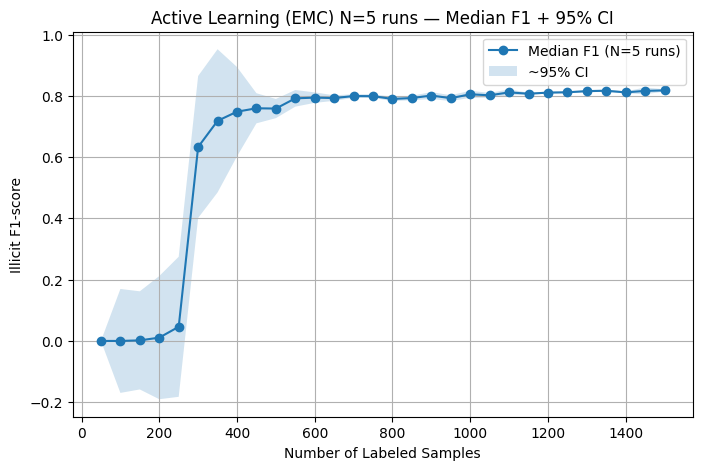

In [15]:
# This part should be invalid
# --- Active Learning: IF + EMC + XGBoost ---
# Paper reproduction version: N=5 runs, median F1 + 95% CI

import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
import xgboost as xgb
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

# Step 1: Load labeled data
labeled_df = pd.read_csv('data/elliptic_txs_features_labeled.csv')

# Check data
print("Loaded labeled CSV rows:", labeled_df.shape[0])
print("Unique time_steps:", sorted(labeled_df['time_step'].unique()))
print("Label distribution:\n", labeled_df['class'].value_counts())

# Step 2: Split train/test by time_step
train_df = labeled_df[labeled_df['time_step'] <= 34].reset_index(drop=True)
test_df  = labeled_df[labeled_df['time_step'] >= 35].reset_index(drop=True)

# Prepare test set
X_test = test_df.drop(columns=['txId', 'time_step', 'class'])
y_test = (test_df['class'] == 1).astype(int)

# Feature columns
feature_columns = [col for col in train_df.columns if col.startswith('feature_') or col.startswith('f')]

# Config
batch_size = 50
max_iterations = 30
N_runs = len(SEEDS)  # Number of runs based on seeds

# Storage for all runs
all_f1_scores = []

# Step 3: Repeat N=5 runs
for run in range(N_runs):
    seed = SEEDS[run]
    print(f"\n==========================")
    print(f"=== Run {run+1}/{N_runs}, Random State {seed} ===")
    print("==========================")
    
    # Initialize pools
    unlabeled_pool = train_df.copy()
    labeled_pool = pd.DataFrame(columns=train_df.columns)
    f1_scores = []
    
    # Warm-up using Isolation Forest
    print("\n===== Warm-up stage: Isolation Forest =====")
    iso_forest = IsolationForest(random_state=seed)
    iso_forest.fit(unlabeled_pool[feature_columns])
    anomaly_scores = -iso_forest.score_samples(unlabeled_pool[feature_columns])
    unlabeled_pool['anomaly_score'] = anomaly_scores
    unlabeled_pool = unlabeled_pool.sort_values(by='anomaly_score', ascending=False).reset_index(drop=True)
    
    found_illicit = False
    pointer = 0
    warmup_illicit = 0
    
    while not found_illicit and pointer < len(unlabeled_pool):
        batch = unlabeled_pool.iloc[pointer:pointer+batch_size]
        labeled_pool = pd.concat([labeled_pool, batch], ignore_index=True)
        pointer += batch_size
        warmup_illicit = (labeled_pool['class'] == 1).sum()
        found_illicit = warmup_illicit > 0
    
    print(f"Warm-up selected {len(labeled_pool)} samples.")
    print(f"Warm-up found {warmup_illicit} illicit samples.")
    
    # Remove warm-up samples
    unlabeled_pool = unlabeled_pool.iloc[pointer:].drop(columns='anomaly_score').reset_index(drop=True)
    
    # Active Learning loop
    iteration = 1
    print("\n===== Active Learning loop: Expected Model Change =====")
    
    while len(unlabeled_pool) > 0 and iteration <= max_iterations:
        X_train = labeled_pool[feature_columns]
        y_train = (labeled_pool['class'] == 1).astype(int)
        
        xgb_clf = xgb.XGBClassifier(
            tree_method='hist',
            eval_metric='logloss',
            n_estimators=100,
            max_depth=6,
            learning_rate=0.1,
            random_state=seed
        )
        
        xgb_clf.fit(X_train, y_train)
        
        y_pred = xgb_clf.predict(X_test)
        f1 = f1_score(y_test, y_pred, pos_label=1)
        f1_scores.append(f1)
        print(f"[Run {seed}] XGBoost_Model_{iteration:02d} illicit F1-score: {f1:.4f}")
        
        # EMC sampling
        X_unlabeled = unlabeled_pool[feature_columns]
        proba = xgb_clf.predict_proba(X_unlabeled)[:, 1]
        emc_score = proba * (1 - proba)
        
        select_idx = np.argsort(-emc_score)[:batch_size]
        new_batch = unlabeled_pool.iloc[select_idx]
        
        labeled_pool = pd.concat([labeled_pool, new_batch], ignore_index=True)
        unlabeled_pool = unlabeled_pool.drop(unlabeled_pool.index[select_idx]).reset_index(drop=True)
        
        iteration += 1
    
    # Save F1-scores of this run
    all_f1_scores.append(f1_scores)

# Step 4: Aggregate results — median + 95% CI
# Pad runs with np.nan to same length
max_len = max(len(scores) for scores in all_f1_scores)
f1_matrix = np.full((N_runs, max_len), np.nan)
for i, scores in enumerate(all_f1_scores):
    f1_matrix[i, :len(scores)] = scores

# Median & CI
median_f1 = np.nanmedian(f1_matrix, axis=0)
std_f1 = np.nanstd(f1_matrix, axis=0)
ci_95 = 1.57 * std_f1 / np.sqrt(N_runs)  # Approx 95% CI

# --- Already computed:
# f1_matrix = shape (5, N_iter)
# median_f1 = np.nanmedian(f1_matrix, axis=0)

# Print Mean F1-score per cycle (across 5 runs)
mean_f1 = np.nanmean(f1_matrix, axis=0)

print("\n===== Mean F1-score across 5 runs per cycle =====")
for i, f1 in enumerate(mean_f1):
    print(f"Cycle {i+1:02d}, Labeled {(i+1)*batch_size} samples: Mean F1 = {f1:.4f}")

# Step 6: Plot
x_axis = np.arange(1, len(median_f1)+1) * batch_size

plt.figure(figsize=(8, 5))
plt.plot(x_axis, median_f1, marker='o', label='Median F1 (N=5 runs)')
plt.fill_between(x_axis, median_f1 - ci_95, median_f1 + ci_95, alpha=0.2, label='~95% CI')
plt.title("Active Learning (EMC) N=5 runs — Median F1 + 95% CI")
plt.xlabel("Number of Labeled Samples")
plt.ylabel("Illicit F1-score")
plt.legend()
plt.grid(True)
plt.show()

Loaded labeled CSV rows: 46564
Unique time_steps: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(18), np.int64(19), np.int64(20), np.int64(21), np.int64(22), np.int64(23), np.int64(24), np.int64(25), np.int64(26), np.int64(27), np.int64(28), np.int64(29), np.int64(30), np.int64(31), np.int64(32), np.int64(33), np.int64(34), np.int64(35), np.int64(36), np.int64(37), np.int64(38), np.int64(39), np.int64(40), np.int64(41), np.int64(42), np.int64(43), np.int64(44), np.int64(45), np.int64(46), np.int64(47), np.int64(48), np.int64(49)]
Label distribution:
 class
2.0    42019
1.0     4545
Name: count, dtype: int64

=== Run 1/5, Random State 42

===== Warm-up stage: Isolation Forest =====
Warm-up selected 1450 samples.
Warm-up found 1 illicit samples.

===== Active Learning loop: Uncertainty Sampling ====

/var/folders/2v/617m0pq96qq942zr8nbfyzch0000gn/T/ipykernel_21374/38398947.py:64: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  labeled_pool = pd.concat([labeled_pool, batch], ignore_index=True)


[Run 1] XGBoost_Model_01 illicit F1-score: 0.0000
[Run 1] XGBoost_Model_02 illicit F1-score: 0.6038
[Run 1] XGBoost_Model_03 illicit F1-score: 0.5877
[Run 1] XGBoost_Model_04 illicit F1-score: 0.6042
[Run 1] XGBoost_Model_05 illicit F1-score: 0.6802
[Run 1] XGBoost_Model_06 illicit F1-score: 0.7535
[Run 1] XGBoost_Model_07 illicit F1-score: 0.7183
[Run 1] XGBoost_Model_08 illicit F1-score: 0.7686
[Run 1] XGBoost_Model_09 illicit F1-score: 0.8048
[Run 1] XGBoost_Model_10 illicit F1-score: 0.7983
[Run 1] XGBoost_Model_11 illicit F1-score: 0.8013
[Run 1] XGBoost_Model_12 illicit F1-score: 0.8073
[Run 1] XGBoost_Model_13 illicit F1-score: 0.8023
[Run 1] XGBoost_Model_14 illicit F1-score: 0.7841
[Run 1] XGBoost_Model_15 illicit F1-score: 0.7963
[Run 1] XGBoost_Model_16 illicit F1-score: 0.8101
[Run 1] XGBoost_Model_17 illicit F1-score: 0.8012
[Run 1] XGBoost_Model_18 illicit F1-score: 0.8127
[Run 1] XGBoost_Model_19 illicit F1-score: 0.8233
[Run 1] XGBoost_Model_20 illicit F1-score: 0.8049


/var/folders/2v/617m0pq96qq942zr8nbfyzch0000gn/T/ipykernel_21374/38398947.py:64: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  labeled_pool = pd.concat([labeled_pool, batch], ignore_index=True)


Warm-up selected 2350 samples.
Warm-up found 1 illicit samples.

===== Active Learning loop: Uncertainty Sampling =====
[Run 2] XGBoost_Model_01 illicit F1-score: 0.0000
[Run 2] XGBoost_Model_02 illicit F1-score: 0.0000
[Run 2] XGBoost_Model_03 illicit F1-score: 0.0018
[Run 2] XGBoost_Model_04 illicit F1-score: 0.0107
[Run 2] XGBoost_Model_05 illicit F1-score: 0.0462
[Run 2] XGBoost_Model_06 illicit F1-score: 0.6329
[Run 2] XGBoost_Model_07 illicit F1-score: 0.7437
[Run 2] XGBoost_Model_08 illicit F1-score: 0.7481
[Run 2] XGBoost_Model_09 illicit F1-score: 0.7592
[Run 2] XGBoost_Model_10 illicit F1-score: 0.7661
[Run 2] XGBoost_Model_11 illicit F1-score: 0.7846
[Run 2] XGBoost_Model_12 illicit F1-score: 0.7998
[Run 2] XGBoost_Model_13 illicit F1-score: 0.7947
[Run 2] XGBoost_Model_14 illicit F1-score: 0.8093
[Run 2] XGBoost_Model_15 illicit F1-score: 0.8155
[Run 2] XGBoost_Model_16 illicit F1-score: 0.7858
[Run 2] XGBoost_Model_17 illicit F1-score: 0.7824
[Run 2] XGBoost_Model_18 illic

/var/folders/2v/617m0pq96qq942zr8nbfyzch0000gn/T/ipykernel_21374/38398947.py:64: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  labeled_pool = pd.concat([labeled_pool, batch], ignore_index=True)


Warm-up selected 2100 samples.
Warm-up found 1 illicit samples.

===== Active Learning loop: Uncertainty Sampling =====
[Run 3] XGBoost_Model_01 illicit F1-score: 0.0000
[Run 3] XGBoost_Model_02 illicit F1-score: 0.0000
[Run 3] XGBoost_Model_03 illicit F1-score: 0.0000
[Run 3] XGBoost_Model_04 illicit F1-score: 0.0035
[Run 3] XGBoost_Model_05 illicit F1-score: 0.0000
[Run 3] XGBoost_Model_06 illicit F1-score: 0.0375
[Run 3] XGBoost_Model_07 illicit F1-score: 0.0649
[Run 3] XGBoost_Model_08 illicit F1-score: 0.4306
[Run 3] XGBoost_Model_09 illicit F1-score: 0.6537
[Run 3] XGBoost_Model_10 illicit F1-score: 0.7087
[Run 3] XGBoost_Model_11 illicit F1-score: 0.7917
[Run 3] XGBoost_Model_12 illicit F1-score: 0.7940
[Run 3] XGBoost_Model_13 illicit F1-score: 0.7863
[Run 3] XGBoost_Model_14 illicit F1-score: 0.8016
[Run 3] XGBoost_Model_15 illicit F1-score: 0.8104
[Run 3] XGBoost_Model_16 illicit F1-score: 0.7851
[Run 3] XGBoost_Model_17 illicit F1-score: 0.8024
[Run 3] XGBoost_Model_18 illic

/var/folders/2v/617m0pq96qq942zr8nbfyzch0000gn/T/ipykernel_21374/38398947.py:64: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  labeled_pool = pd.concat([labeled_pool, batch], ignore_index=True)


Warm-up selected 2550 samples.
Warm-up found 1 illicit samples.

===== Active Learning loop: Uncertainty Sampling =====
[Run 4] XGBoost_Model_01 illicit F1-score: 0.0000
[Run 4] XGBoost_Model_02 illicit F1-score: 0.0000
[Run 4] XGBoost_Model_03 illicit F1-score: 0.0000
[Run 4] XGBoost_Model_04 illicit F1-score: 0.0000
[Run 4] XGBoost_Model_05 illicit F1-score: 0.0000
[Run 4] XGBoost_Model_06 illicit F1-score: 0.0000
[Run 4] XGBoost_Model_07 illicit F1-score: 0.0654
[Run 4] XGBoost_Model_08 illicit F1-score: 0.2861
[Run 4] XGBoost_Model_09 illicit F1-score: 0.6454
[Run 4] XGBoost_Model_10 illicit F1-score: 0.6724
[Run 4] XGBoost_Model_11 illicit F1-score: 0.7004
[Run 4] XGBoost_Model_12 illicit F1-score: 0.7386
[Run 4] XGBoost_Model_13 illicit F1-score: 0.7643
[Run 4] XGBoost_Model_14 illicit F1-score: 0.7949
[Run 4] XGBoost_Model_15 illicit F1-score: 0.7932
[Run 4] XGBoost_Model_16 illicit F1-score: 0.8014
[Run 4] XGBoost_Model_17 illicit F1-score: 0.7927
[Run 4] XGBoost_Model_18 illic

/var/folders/2v/617m0pq96qq942zr8nbfyzch0000gn/T/ipykernel_21374/38398947.py:64: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  labeled_pool = pd.concat([labeled_pool, batch], ignore_index=True)


Warm-up selected 1250 samples.
Warm-up found 1 illicit samples.

===== Active Learning loop: Uncertainty Sampling =====
[Run 5] XGBoost_Model_01 illicit F1-score: 0.0000
[Run 5] XGBoost_Model_02 illicit F1-score: 0.0000
[Run 5] XGBoost_Model_03 illicit F1-score: 0.1022
[Run 5] XGBoost_Model_04 illicit F1-score: 0.5729
[Run 5] XGBoost_Model_05 illicit F1-score: 0.6776
[Run 5] XGBoost_Model_06 illicit F1-score: 0.6747
[Run 5] XGBoost_Model_07 illicit F1-score: 0.7689
[Run 5] XGBoost_Model_08 illicit F1-score: 0.7951
[Run 5] XGBoost_Model_09 illicit F1-score: 0.8014
[Run 5] XGBoost_Model_10 illicit F1-score: 0.7584
[Run 5] XGBoost_Model_11 illicit F1-score: 0.8046
[Run 5] XGBoost_Model_12 illicit F1-score: 0.7870
[Run 5] XGBoost_Model_13 illicit F1-score: 0.7925
[Run 5] XGBoost_Model_14 illicit F1-score: 0.7992
[Run 5] XGBoost_Model_15 illicit F1-score: 0.7988
[Run 5] XGBoost_Model_16 illicit F1-score: 0.7897
[Run 5] XGBoost_Model_17 illicit F1-score: 0.7746
[Run 5] XGBoost_Model_18 illic

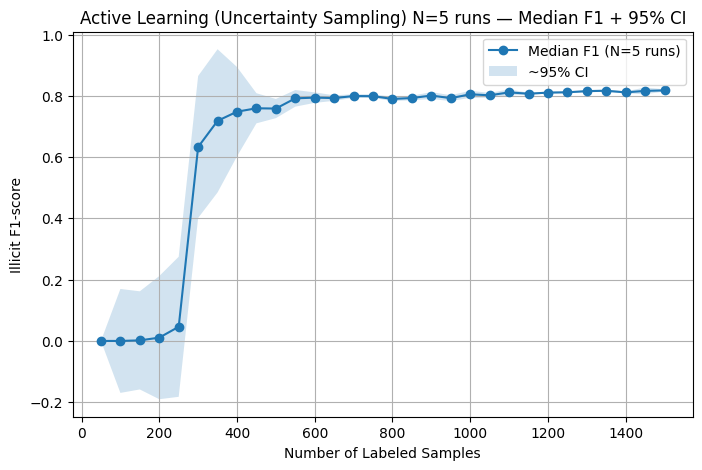

In [16]:
# --- Active Learning: IF + Uncertainty Sampling + XGBoost ---
# Paper reproduction version: N=5 runs, median F1 + 95% CI

import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
import xgboost as xgb
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

# Step 1: Load labeled data
labeled_df = pd.read_csv('data/elliptic_txs_features_labeled.csv')

# Check data
print("Loaded labeled CSV rows:", labeled_df.shape[0])
print("Unique time_steps:", sorted(labeled_df['time_step'].unique()))
print("Label distribution:\n", labeled_df['class'].value_counts())

# Step 3: Split train/test by time_step
train_df = labeled_df[labeled_df['time_step'] <= 34].reset_index(drop=True)
test_df  = labeled_df[labeled_df['time_step'] >= 35].reset_index(drop=True)

# Prepare test set
X_test = test_df.drop(columns=['txId', 'time_step', 'class'])
y_test = (test_df['class'] == 1).astype(int)

# Feature columns
feature_columns = [col for col in train_df.columns if col.startswith('feature_') or col.startswith('f')]

# Config
batch_size = 50
max_iterations = 30  # 30 iterations = up to 1500 samples
N_runs = len(SEEDS)  # Number of runs based on seeds

# Storage for all runs
all_f1_scores = []

# Step 4: Repeat N=5 runs
for run in range(N_runs):
    seed = SEEDS[run]
    print(f"\n==========================")
    print(f"=== Run {run+1}/{N_runs}, Random State {seed}")
    print("==========================")
    
    # Initialize pools
    unlabeled_pool = train_df.copy()
    labeled_pool = pd.DataFrame(columns=train_df.columns)
    f1_scores = []
    
    # Warm-up using Isolation Forest
    print("\n===== Warm-up stage: Isolation Forest =====")
    iso_forest = IsolationForest(random_state=seed)
    iso_forest.fit(unlabeled_pool[feature_columns])
    anomaly_scores = -iso_forest.score_samples(unlabeled_pool[feature_columns])
    unlabeled_pool['anomaly_score'] = anomaly_scores
    unlabeled_pool = unlabeled_pool.sort_values(by='anomaly_score', ascending=False).reset_index(drop=True)
    
    found_illicit = False
    pointer = 0
    warmup_illicit = 0
    
    while not found_illicit and pointer < len(unlabeled_pool):
        batch = unlabeled_pool.iloc[pointer:pointer+batch_size]
        labeled_pool = pd.concat([labeled_pool, batch], ignore_index=True)
        pointer += batch_size
        warmup_illicit = (labeled_pool['class'] == 1).sum()
        found_illicit = warmup_illicit > 0
    
    print(f"Warm-up selected {len(labeled_pool)} samples.")
    print(f"Warm-up found {warmup_illicit} illicit samples.")
    
    # Remove warm-up samples
    unlabeled_pool = unlabeled_pool.iloc[pointer:].drop(columns='anomaly_score').reset_index(drop=True)
    
    # Active Learning loop
    iteration = 1
    print("\n===== Active Learning loop: Uncertainty Sampling =====")
    
    while len(unlabeled_pool) > 0 and iteration <= max_iterations:
        X_train = labeled_pool[feature_columns]
        y_train = (labeled_pool['class'] == 1).astype(int)
        
        xgb_clf = xgb.XGBClassifier(
            tree_method='hist',
            eval_metric='logloss',
            n_estimators=100,
            max_depth=6,
            learning_rate=0.1,
            random_state=seed
        )
        
        xgb_clf.fit(X_train, y_train)
        
        y_pred = xgb_clf.predict(X_test)
        f1 = f1_score(y_test, y_pred, pos_label=1)
        f1_scores.append(f1)
        print(f"[Run {run+1}] XGBoost_Model_{iteration:02d} illicit F1-score: {f1:.4f}")
        
        # Uncertainty sampling
        X_unlabeled = unlabeled_pool[feature_columns]
        proba = xgb_clf.predict_proba(X_unlabeled)[:, 1]
        uncertainty = np.abs(proba - 0.5)
        
        select_idx = np.argsort(uncertainty)[:batch_size]
        new_batch = unlabeled_pool.iloc[select_idx]
        
        labeled_pool = pd.concat([labeled_pool, new_batch], ignore_index=True)
        unlabeled_pool = unlabeled_pool.drop(unlabeled_pool.index[select_idx]).reset_index(drop=True)
        
        iteration += 1
    
    # Save F1-scores of this run
    all_f1_scores.append(f1_scores)

# Step 5: Aggregate results — median + 95% CI
# Pad runs with np.nan to same length
max_len = max(len(scores) for scores in all_f1_scores)
f1_matrix = np.full((N_runs, max_len), np.nan)
for i, scores in enumerate(all_f1_scores):
    f1_matrix[i, :len(scores)] = scores


# Step 5b: Print Mean F1-score across 5 runs per cycle
mean_f1 = np.nanmean(f1_matrix, axis=0)

print("\n===== Mean F1-score across 5 runs per cycle =====")
for i, f1 in enumerate(mean_f1):
    print(f"Cycle {i+1:02d}, Labeled {(i+1)*batch_size} samples: Mean F1 = {f1:.4f}")


# Median & CI
median_f1 = np.nanmedian(f1_matrix, axis=0)
std_f1 = np.nanstd(f1_matrix, axis=0)
ci_95 = 1.57 * std_f1 / np.sqrt(N_runs)  # Approx 95% CI

# Step 6: Plot
x_axis = np.arange(1, len(median_f1)+1) * batch_size

plt.figure(figsize=(8, 5))
plt.plot(x_axis, median_f1, marker='o', label='Median F1 (N=5 runs)')
plt.fill_between(x_axis, median_f1 - ci_95, median_f1 + ci_95, alpha=0.2, label='~95% CI')
plt.title("Active Learning (Uncertainty Sampling) N=5 runs — Median F1 + 95% CI")
plt.xlabel("Number of Labeled Samples")
plt.ylabel("Illicit F1-score")
plt.legend()
plt.grid(True)
plt.show()